In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Let's start by loading our data

# Starting with the labels
with open("./data/processed_training_labels.csv") as labels_file:
    labels_string = labels_file.read()
    labels = np.array(labels_string.split(','), dtype=int)
    
# Recall we had 60000 images. Let's make sure we didn't lose anythin
assert len(labels) == 60000

# Now for the images
images = []
with open("./data/processed_training_images") as images_file:
    raw_image_strings = images_file.readlines()
    for img_string in raw_image_strings:
        img_flat = np.array(img_string.split(","), dtype=np.double)
        img = np.reshape(img_flat, (28,28))
        images.append(img)
        
# Again, let's do some random spot checking to make sure everything is as we expect
assert len(images) == 60000
i1,i2,i3 = np.random.randint(0, 60000, 3)
assert images[i1].shape == (28,28)
assert images[i2].shape == (28,28)
assert images[i3].shape == (28,28)

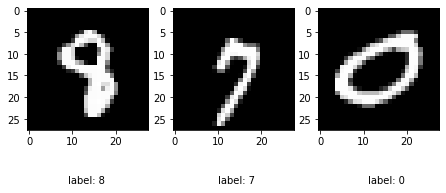

In [3]:
# And again, we'll just print out some images and their labels for good measure 

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,4,1)
plt.text(9,40,f"label: {labels[i1]}")
plt.imshow(images[i1], cmap='gray')
fig.add_subplot(1,4,2)
plt.text(10,40,f"label: {labels[i2]}")
plt.imshow(images[i2], cmap='gray')
fig.add_subplot(1,4,3)
plt.text(11,40,f"label: {labels[i3]}")
plt.imshow(images[i3], cmap='gray')

In [4]:
## Okay! Now the fun begins.
# To start, let's just get everything over to Torch
t_labels = torch.tensor(labels).long()
t_images = torch.tensor(images)

train_images = t_images.reshape(60000, 1, 784).float()
train_labels = torch.zeros(60000, 1, 10)
for i, label in enumerate(t_labels):
    train_labels[i][0][label.item()] = 1

#_ = train_images[:][:].div_(255.0)  # Normalize the pixel values to between [0,1.0]
#train_labels = train_labels.flip(0)
#train_images = train_images.flip(0)

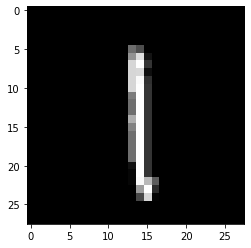

In [5]:
# And we can take a look at their shapes
import matplotlib.pyplot as plt
z = np.random.randint(0, 60000)
plt.imshow(train_images[z][0].reshape(28,28), cmap='gray')

In [34]:
# TODO: !DF! Try just one fully connected layer
# TODO: !DF! Write explanation on MSELoss()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1,1,3)  # stride = 1
        #self.drop1 = nn.(389,p=.2) 
        #self.norm1 = nn.LayerNorm(782)
        self.fc1 = nn.Linear(782,100) # 80
        #self.drop2 = nn.Dropout()
        self.norm1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 10)
        #self.fc3 = nn.Linear(100, 10) # 80
        
    def forward(self, x):
        # https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
        x = F.tanh(self.conv1(x))
        #x = F.sigmoid(self.conv1(x))
        #x = self.drop1(x)
        x = x.view(-1, x.shape[1:].numel())  # Linear input should be in shape [batch_size, features x height x width]
        x = F.tanh(self.fc1(x))
        #x = F.sigmoid(self.fc1(x))
        
        
        #x = F.sigmoid(self.fc2(x))
        #x = self.drop2(x)
        #x = F.relu(self.fc2(x))
        # What we're doing here is re-shaping x to remove the channel dimension. This was confusing for me to understand. But
        # basically pytorch expects everything in mini batches. So incoming data is in the form (images_per_batch,
        # channels_per_image, (h,w)). In our case, we have (4,1,784), because we have 4 images per batch, 1 channel per image,
        # and a flat vector of length 784 representing that channel (and because we have only one channel, that image). Our
        # output, however, is channel indepedent. We want our output to be in the shape (images_per_batch,
        # {single_image_output_shape}). In that case, our final output shape is (4, 10)
        return self.fc2(self.norm1(x))

## 100 -> ~76 ~78 ~78 ~78%
## 80 -> ~78 ~76 ~ 77 ~78%

## 100 with max_pool -> 71%, 73% 71%
#https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073
# 5 Epochs with +-[1/sqrt(n)] weights + pytorch bias, Sigmoid, Kernel Size 3: 85%, 86%, 86%
# 5 Epochs with pytorch weights/bias, Sigmoid, Kernel Size 3: 87%, 86%, 86%, 85%
# 5 Epochs with +-[1/sqrt(n)] weights + 0 bias, Sigmoid, Kernel Size 3: 86%, 86%, 86%, 85%
# 5 Epochs with +-[1/sqrt(n)] weights and bias, Sigmoid, Kernel Size 3: 86%, 85%, 86%
#  5 Epochs with Normalized Xavier weights and 0 bias, Sigmoid, Kernel Size 3: 87%, 87%, 86%,(5) -- 90.35% 90.44%  (10) **
#  5 Epochs with Normalized Xavier weights and 0 bias, Sigmoid, Kernel Size 5: 86%, 86%, 86% (5) -- 89.31% 90.03%  (10)
#  5 Epochs with Normalized Xavier weights and 0 bias, Sigmoid, Kernel Size 8: 87%, 86%, 87% (5) -- 89.79% 88.58%  (10)

## TODO: !DF! Best of the normalized Xavier head-to-head with pytorch defaults, 10 epochs, track loss

In [41]:
net = Net()
net = net
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
# https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
# TODO:!DF! test with and without these weights
#net.fc1.weight.data.uniform_(-1.0/np.sqrt(782),1.0/np.sqrt(782))
#_ = net.fc2.weight.data.uniform_(-1.0/np.sqrt(100),1.0/np.sqrt(100))
#net.fc1.bias.data.uniform_(-1.0/np.sqrt(782),1.0/np.sqrt(782))
#_ =  net.fc2.bias.data.uniform_(-1.0/np.sqrt(100),1.0/np.sqrt(100))-np.sqrt(6.0)


In [42]:
from IPython.display import display, clear_output
criterion = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01)
mb_size = 4
num_batches = len(train_images) // mb_size

for epoch in range(3):
    running_loss = 0.0
    perm = torch.randperm(60000)
    #for i in range(0,len(train_images), 4):
    for i in range(0, num_batches):
        net.zero_grad()
        indexes = perm[i*mb_size:(i+1) * mb_size]
        batch = train_images[indexes]
        targets = t_labels[indexes]
        out = net.forward(batch)
            #loss = criterion(out, train_labels[i:i+4])
        loss = criterion2(out, targets)
        loss.backward()
        running_loss += loss.item()
        if i % 1000 == 999:
                ## I recommend doing things like this. It helped me catch mistakes
                #print(batch[0][0])
                #plt.imshow(batch[0][0].reshape((28,28)), cmap='gray')
                #plt.show()
                #print(targets[0])
            clear_output(wait=True)
            display(f"Epoch: {epoch}, Batch: {i}, running_loss: {running_loss}")
            running_loss = 0.0
        for f in net.parameters():
            f.data = f.data - f.grad.data * .01
                ####f.data.sub_(f.grad.data * 0.01)
            #f.data.sub_(f.grad.data * 0.1)

'Epoch: 2, Batch: 14999, running_loss: 363.9663696284406'

In [ ]:
import copy
default_wb_results = copy.deepcopy(training_outs)
#norm_xav_wb_results = copy.deepcopy(training_outs)
print(np.mean(norm_xav_wb_results))
print(np.mean(default_wb_results))

In [ ]:
torch.argmax(net(t_images[750].flatten().float().unsqueeze(0).unsqueeze(0)))

In [312]:
t.view(4,10)

tensor([[ 0.1536,  0.2882, -0.4127, -0.0651,  0.3566,  0.1120, -0.2545,  0.0706,
         -0.7031, -0.1304],
        [ 0.1242,  0.2807, -0.4189, -0.0767,  0.3486,  0.1419, -0.2370,  0.0854,
         -0.6636, -0.1226],
        [ 0.1348,  0.2714, -0.3890, -0.0232,  0.3746,  0.1413, -0.2490,  0.0728,
         -0.6497, -0.1143],
        [ 0.0769,  0.2961, -0.3989, -0.0508,  0.3697,  0.1184, -0.2663,  0.0687,
         -0.6492, -0.1373]], grad_fn=<ViewBackward>)

In [37]:
with open("./data/processed_testing_labels.csv") as labels_file:
    labels_string = labels_file.read()
    testing_labels = np.array(labels_string.split(','), dtype=int)
    
# Recall we had 60000 images. Let's make sure we didn't lose anythin
assert len(testing_labels) == 10000

# Now for the images
testing_images = []
with open("./data/processed_testing_images") as images_file:
    raw_image_strings = images_file.readlines()
    for img_string in raw_image_strings:
        img_flat = np.array(img_string.split(","), dtype=np.double)
        img = np.reshape(img_flat, (28,28))
        testing_images.append(img)

In [38]:
t_test_labels = torch.tensor(testing_labels)
t_test_images = torch.tensor(testing_images)

In [39]:
test_imgs = t_test_images
test_labels = t_test_labels
correct = []
net.eval()
for i,img in enumerate(test_imgs):
    res = torch.argmax(net(img.flatten().float().unsqueeze(0).unsqueeze(0)))
    targ = test_labels[i]
    if res == targ:
        correct.append(1)
    else:
        correct.append(0)

print(f"{sum(correct)} / {len(correct)}")

9661 / 10000


In [28]:
img = t_images[9496]
plt.imshow(img, cmap='gray')

NameError: name 'plt' is not defined

In [ ]:
torch.argmax(net(img.flatten().float().unsqueeze(0).unsqueeze(0)))

In [268]:
out[0].view(-1)

tensor([-1.1050,  0.4207,  0.8344,  8.9818, -2.0588,  2.4454, -7.6334, -3.6497,
         2.2114, -0.3338], grad_fn=<ViewBackward>)

In [183]:
torch.argmax(out, dim=2)

tensor([[9],
        [3],
        [8],
        [2]])

In [ ]:
##torch.save(net, "./models/1dC2fc85")
##torch.save(net.state_dict(), "./models/1dC2fc85.state_dict")

In [ ]:
train_labels.flip(0)

In [ ]:
my_img = train_images[0][0]
my_conv1d = nn.Conv1d(1,2,2)
my_conv1d(my_img.unsqueeze(0).unsqueeze(0))[0]


In [ ]:
f = nn.Conv1d(1,1,3)

In [ ]:
f(train_images[0].unsqueeze(0)).shape

In [ ]:
104/26

In [68]:
ll = nn.Linear(782,100)
ll2 = nn.Linear(782, 100)
ll2.weight.data.uniform_(-1.0/np.sqrt(782),1.0/np.sqrt(782))

tensor([[-0.0344, -0.0227, -0.0099,  ...,  0.0357,  0.0121, -0.0129],
        [-0.0289, -0.0260, -0.0018,  ...,  0.0205, -0.0217,  0.0199],
        [ 0.0091,  0.0305,  0.0191,  ..., -0.0006,  0.0047, -0.0305],
        ...,
        [-0.0057,  0.0190, -0.0134,  ..., -0.0067,  0.0096, -0.0161],
        [ 0.0202, -0.0128, -0.0338,  ..., -0.0176, -0.0176,  0.0211],
        [-0.0263, -0.0035,  0.0092,  ..., -0.0211, -0.0109, -0.0111]])

In [69]:
ll.weight.data.median()

tensor(3.6307e-05)

In [70]:
ll2.weight.data.median()

tensor(-8.7258e-05)

In [82]:
ll.weight.size(1)

782

In [357]:
out.shape

torch.Size([4, 10])

In [14]:
losses.shape

(5, 15000, 1)

In [18]:
losses[0][0] = 1

In [410]:
out.shape.numel()

40

In [19]:
losses[0][0]

1.0

In [453]:
out.size()[2:]

torch.Size([10])

In [455]:
t_labels.size()[1:]

torch.Size([])

In [262]:
p = net.parameters()

In [264]:
list(p)

[Parameter containing:
 tensor([[[ 1.5822,  2.0050, -0.5929]]], requires_grad=True),
 Parameter containing:
 tensor([-1.1087], requires_grad=True),
 Parameter containing:
 tensor([[-0.0119, -0.0085,  0.0110,  ...,  0.0116, -0.0096, -0.0135],
         [-0.0320,  0.0286, -0.0208,  ..., -0.0038, -0.0199, -0.0130],
         [-0.0223,  0.0322,  0.0007,  ..., -0.0159, -0.0188, -0.0315],
         ...,
         [-0.0292,  0.0170,  0.0317,  ...,  0.0107, -0.0131, -0.0099],
         [ 0.0201, -0.0065,  0.0112,  ..., -0.0329, -0.0110, -0.0011],
         [-0.0252, -0.0218, -0.0027,  ...,  0.0336,  0.0312, -0.0325]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0291,  0.0315,  0.0305, -0.0010,  0.0330,  0.0426, -0.0345,  0.0205,
         -0.0040,  0.0300, -0.0284,  0.0403, -0.0158,  0.0218,  0.0196, -0.0311,
          0.0297,  0.0403, -0.0171,  0.0373,  0.0035,  0.0131,  0.0121, -0.0083,
          0.0167, -0.0325, -0.0125,  0.0208, -0.0074,  0.0100,  0.0063,  0.0023,
         -0.

In [282]:
net.fc1.bias

Parameter containing:
tensor([-0.0080, -0.0141,  0.0383, -0.0103,  0.0013,  0.0218, -0.0356, -0.0228,
        -0.0382, -0.0159, -0.0151,  0.0460, -0.0070,  0.0435, -0.0254, -0.0147,
        -0.0032,  0.0105, -0.0077,  0.0004, -0.0047, -0.0055, -0.0339,  0.0173,
        -0.0308, -0.0061,  0.0225, -0.0354, -0.0293, -0.0048, -0.0192, -0.0218,
         0.0065,  0.0266, -0.0079, -0.0133,  0.0077,  0.0481, -0.0287,  0.0276,
        -0.0239,  0.0289, -0.0095, -0.0055, -0.0284, -0.0274,  0.0205,  0.0408,
         0.0140, -0.0043,  0.0287, -0.0078,  0.0090,  0.0165, -0.0393,  0.0231,
        -0.0165, -0.0010, -0.0238,  0.0230,  0.0002, -0.0006, -0.0164,  0.0537,
         0.0321,  0.0053, -0.0277,  0.0187,  0.0066, -0.0011,  0.0217,  0.0270,
        -0.0283, -0.0403,  0.0196,  0.0299, -0.0023,  0.0104, -0.0132,  0.0106,
         0.0119,  0.0370,  0.0017,  0.0263,  0.0404, -0.0017, -0.0151,  0.0179,
        -0.0050, -0.0308,  0.0082, -0.0037, -0.0387,  0.0266,  0.0246, -0.0437,
        -0.0268, -

In [297]:
f.data

tensor([[ 2.0761e+00, -1.6235e+01,  2.8565e+01, -2.9188e+01,  5.7104e+01,
          2.5931e+01,  1.0913e+02, -4.0174e+01,  3.4021e+01, -3.2643e+00,
          1.5213e+02, -6.2860e+01, -2.4384e+01,  3.4705e+01,  1.7448e+02,
         -7.2245e+01,  3.1114e+01, -6.9633e+01,  4.0884e+02, -2.2795e+01,
         -5.0592e+00, -5.0908e+01, -2.6636e+01,  3.7254e+01, -7.3828e+01,
          9.6459e+01,  6.2397e+01,  3.0369e+01,  2.6805e+01,  2.2060e+01,
         -1.1421e+01, -5.5894e+01,  6.9189e+01,  1.8263e+01, -4.3208e+01,
         -3.9489e+00, -3.2699e+01,  2.0531e+01,  8.4536e+00,  9.1575e+01,
          1.6691e+01,  3.2863e+01, -1.0319e+02, -2.1753e+00, -3.5632e+01,
         -9.1058e+01, -1.3955e+01, -3.4793e+01, -3.9361e+01,  1.4621e+01,
          6.0975e+01,  1.9006e+01,  4.7710e+01, -4.9742e+01,  1.2436e+01,
          1.6198e+01, -7.0281e+00,  2.7315e+01,  2.5393e+01, -5.8661e+01,
          1.7992e+01,  2.6399e+02,  5.6909e+00, -1.4564e+01,  2.7287e+01,
         -2.3878e+01,  1.9201e+02,  3.

In [6]:
import pandas as pd
vec = np.random.normal(0,1,720)
df = pd.DataFrame(vec)

In [7]:
df = df.cumsum()

<AxesSubplot:>

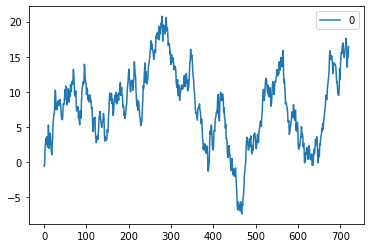

In [8]:
df.plot()